# Named Entity Recognition
- using conditional random fields

# 1)- Importing key modules

In [0]:
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function

# I am an engineer. I care only about error not warning. So, let's be maverick and ignore warnings.
import warnings
warnings.filterwarnings('ignore')

In [0]:
# For data processing and maths

import pandas as pd
import numpy as np
#For Visuals
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [3]:
# for model

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

Using TensorFlow backend.


In [4]:
! pip install version_information

In [5]:
# first install: pip install version_information
%reload_ext version_information
%version_information pandas,numpy,keras, seaborn, matplotlib

Software versions
Python 3.6.8 64bit [GCC 8.3.0]
IPython 5.5.0
OS Linux 4.14.137+ x86_64 with Ubuntu 18.04 bionic
pandas 0.25.3
numpy 1.17.4
keras 2.2.5
seaborn 0.9.0
matplotlib 3.1.1
Tue Nov 26 20:53:40 2019 UTC

# 2)- Getting Data

https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus

In [0]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1")

In [7]:
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


There are missing values. We shall fill wit ffill. Also it makes sense as sentence 1 contains all words and then comes sentence2.

In [0]:
data = data.fillna(method="ffill")

In [9]:
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [10]:
data.tail()

,Sentence #,Word,POS,Tag
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


So, in total we have 47959 sentences in our data. Let's see how many words we have

In [11]:
len(data["Word"])

1048575

Total words are 1048575. But , there might be many repeating words. Let's find unique words or vocab.

In [12]:
len(data["Word"].unique())

35178

In [0]:
# making list of unique "word" feature
words = list(set(data["Word"].values))

In [14]:
words[:5]

['flood-prone', '143', 'Barman', 'preparatory', 'intensive']

In [15]:
n_words = len(words)
n_words

35178

We have 47959 sentences containing 35178 unique words

In [0]:
tags = list(set(data["Tag"].values))

In [33]:
n_tags = len(tags); n_tags

17

In [16]:
# let's see how many tag we have in our data or what kind of tags we have

data.Tag.value_counts()

O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: Tag, dtype: int64

In [17]:
len(data.Tag.value_counts())

17

In [18]:
# how about POS

len(data.POS.value_counts())

42

#3)- Retrieving sentence

- SentenceGetter function

In [0]:
d=data

In [0]:
d=d.groupby(["Sentence #","Tag"]).size()

In [21]:
d.head()

Sentence #    Tag  
Sentence: 1   B-geo     2
              B-gpe     1
              O        21
Sentence: 10  B-gpe     1
              B-org     1
dtype: int64

In [0]:
d_tag=d.unstack('Tag')

In [23]:
d_tag

Tag,B-art,B-eve,B-geo,B-gpe,B-nat,B-org,B-per,B-tim,I-art,I-eve,I-geo,I-gpe,I-nat,I-org,I-per,I-tim,O
Sentence #,,,,,,,,,,,,,,,,,
Sentence: 1,NaN,NaN,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0
Sentence: 10,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0
Sentence: 100,NaN,NaN,2.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,27.0
Sentence: 1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0
Sentence: 10000,NaN,NaN,3.0,2.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sentence: 9995,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,27.0
Sentence: 9996,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,21.0
Sentence: 9997,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,24.0


Thanks to blog by http://www.depends-on-the-definition.com/introduction-named-entity-recognition-python/

We can use a simpler solution for this 

In [0]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [0]:
getter = SentenceGetter(data)

In [0]:
sent = getter.get_next()

In [27]:
print(sent)

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


In [0]:
# get all sentences in dataset
sentences = getter.sentences

In [0]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

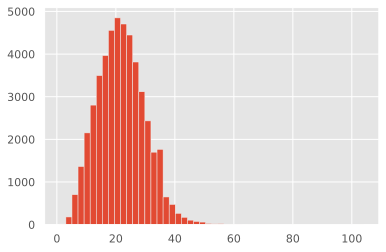

In [30]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [0]:
max_len = 50
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [35]:
word2idx["Obama"]

14987

In [36]:
tag2idx["B-geo"]

4

# 4)- Feature preparation

### 4a)- pad the sequence

map the senctences to a sequence of numbers and then pad the sequence

In [0]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]

In [39]:
X[:1]

[[19500,
  34450,
  8409,
  23648,
  4511,
  34128,
  27743,
  34353,
  30625,
  4558,
  2948,
  5905,
  7337,
  28548,
  9845,
  4558,
  1057,
  34450,
  8209,
  29231,
  23266,
  12097,
  9577,
  4545]]

In [0]:
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words - 1)

In [41]:
X[:1]

array([[19500, 34450,  8409, 23648,  4511, 34128, 27743, 34353, 30625,
         4558,  2948,  5905,  7337, 28548,  9845,  4558,  1057, 34450,
         8209, 29231, 23266, 12097,  9577,  4545, 35177, 35177, 35177,
        35177, 35177, 35177, 35177, 35177, 35177, 35177, 35177, 35177,
        35177, 35177, 35177, 35177, 35177, 35177, 35177, 35177, 35177,
        35177, 35177, 35177, 35177, 35177]], dtype=int32)

In [0]:
# same with y

y = [[tag2idx[w[2]] for w in s] for s in sentences]

In [43]:
y[:1]

[[15,
  15,
  15,
  15,
  15,
  15,
  4,
  15,
  15,
  15,
  15,
  15,
  4,
  15,
  15,
  15,
  15,
  15,
  12,
  15,
  15,
  15,
  15,
  15]]

In [0]:
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [45]:
y[:1]

array([[15, 15, 15, 15, 15, 15,  4, 15, 15, 15, 15, 15,  4, 15, 15, 15,
        15, 15, 12, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15]], dtype=int32)

### 4b)-Convert labels y to categorial.

In [0]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

### 4c)- split in train and test 

In [0]:
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

# 5) Model Building

In [0]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

In [49]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words, output_dim=50, input_length=max_len)(input)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model = Model(input, out)

In [51]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

In [52]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 50)            1758900   
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 200)           120800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 50, 17)            3417      
Total params: 1,883,117
Trainable params: 1,883,117
Non-trainable params: 0
_________________________________________________________________


In [53]:
history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=5, validation_split=0.1, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 38846 samples, validate on 4317 samples
Epoch 1/5





38846/38846 [==============================] - 301s 8ms/step - loss: 0.1415 - acc: 0.9640 - val_loss: 0.0646 - val_acc: 0.9811
Epoch 2/5
38846/38846 [==============================] - 297s 8ms/step - loss: 0.0549 - acc: 0.9840 - val_loss: 0.0528 - val_acc: 0.9841
Epoch 3/5
38846/38846 [==============================] - 298s 8ms/step - loss: 0.0456 - acc: 0.9866 - val_loss: 0.0500 - val_acc: 0.9852
Epoch 4/5
38846/38846 [==============================] - 292s 8ms/step - loss: 0.0410 - acc: 0.9880 - val_loss: 0.0482 - val_acc: 0.9855
Epoch 5/5
38846/38846 [==============================] - 287s 7ms/step - loss: 0.0382 - acc: 0.9887 - val_loss: 0.0469 - val_acc: 0.9858


In [0]:
hist = pd.DataFrame(history.history)

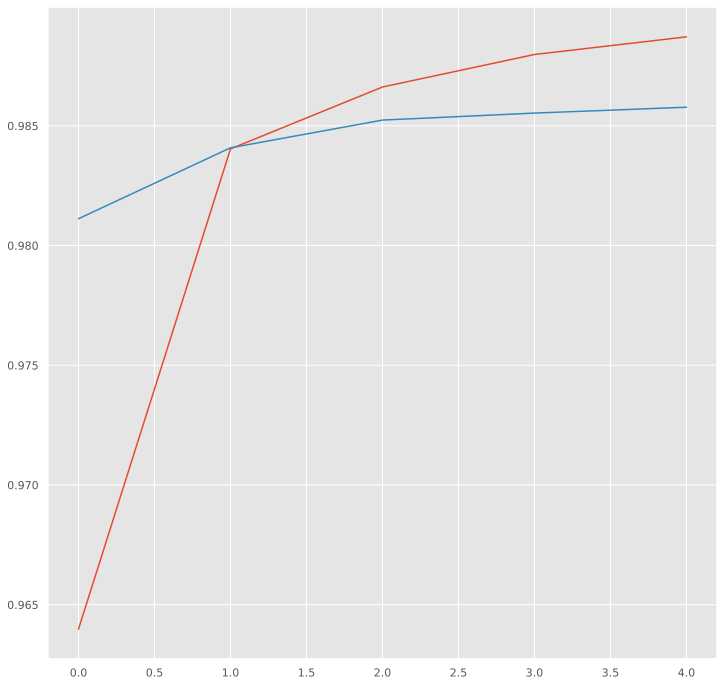

In [55]:
plt.figure(figsize=(12,12))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.show()

# 6)- Prediction

In [56]:
i = 2318
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
for w, pred in zip(X_te[i], p[0]):
    print("{:15}: {}".format(words[w], tags[pred]))

Word            (True ): Pred
He             : O
gave           : O
no             : O
further        : O
details        : O
,              : O
but            : O
said           : O
he             : O
hoped          : O
the            : O
message        : O
would          : O
help           : O
narrow         : O
the            : O
gap            : O
between        : O
Beijing        : B-geo
and            : O
Taipei         : B-geo
.              : O
33-member      : O
33-member      : O
33-member      : O
33-member      : O
33-member      : O
33-member      : O
33-member      : O
33-member      : O
33-member      : O
33-member      : O
33-member      : O
33-member      : O
33-member      : O
33-member      : O
33-member      : O
33-member      : O
33-member      : O
33-member      : O
33-member      : O
33-member      : O
33-member      : O
33-member      : O
33-member      : O
33-member      : O
33-member      : O
33-member      : O
33-member      : O
33-member      : O
